<a href="https://colab.research.google.com/github/mehdi-nait/Heart-Failure-Symptomes-detection/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cloning the github repo cotaining the dataset

In [1]:
!git clone https://github.com/mehdi-nait/Heart-Failure-Symptomes-detection.git

Cloning into 'Heart-Failure-Symptomes-detection'...
remote: Enumerating objects: 3374, done.
remote: Counting objects: 100% (3374/3374), done.
remote: Compressing objects: 100% (3338/3338), done.
remote: Total 3374 (delta 44), reused 3351 (delta 34), pack-reused 0
Receiving objects: 100% (3374/3374), 57.27 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
cp -r Heart-Failure-Symptomes-detection/Data Data

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import Augmentor
#!pip install wandb
#import wandb


logging into wandb to track experiments

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Constructing Dataset class

In [ ]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

NUM_SAMPLES = 30000

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(f"init size : {len(images)}")

images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

collected = list(zip(images,labels))

images = [[np.asarray(Image.open(y)) for y in x] for x in collected]

p = Augmentor.DataPipeline(images)

p.random_distortion(0.8,grid_height=15,grid_width=15,magnitude=5)
p.rotate(1, max_left_rotation=5, max_right_rotation=5)
p.flip_top_bottom(0.5)
p.zoom_random(0.5, percentage_area=0.7)

augmented_images= p.sample(NUM_SAMPLES)

for i in range(len(augmented_images)):
  
  cv2.imwrite(f"{images_path}{i}.png", augmented_images[i][0])
  cv2.imwrite(f"{labels_path}{i}.png", augmented_images[i][1])


print(f"end size : {len(os.listdir(images_path))}")


In [1]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(len(images))
print(len(labels))
images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

for image in images:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

for image in labels:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

NameError: name 'os' is not defined

In [3]:
class Dataset_seg(Dataset):
    """A class used to represent the dataset
    
    Attributes
    ----------

    images : list(str)
        a list of image paths 
    labels : list(str)
        list of labels paths
    size_img : tuple(int,int)
        image and label size
    transform : function
        transformation to be applied on the images/labels
    
    Methods
    -------
    __init__(self,image_dir,label_dir,transform = None)
        instanciates the dataset object
    __len__(self)
        returns the length of the dataset
    __getitem__(self,idx)
        returns a image,label matrices couple after transforamations

    """
    
    def __init__(self,image_dir,label_dir,transform = None):

        
        self.images = os.listdir(image_dir)
        self.images = [image_dir+x for x in self.images]
        
        self.labels = os.listdir(label_dir)
        self.labels = [label_dir+x for x in self.labels]
        self.transform = transform
        self.size_img = (256,256)
        
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self,idx):

        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image,self.size_img)
        label = cv2.resize(label,self.size_img)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = image.to(device)
        label = label.to(device)
        return image,label
        
        

To do : Elastic transformations data augmentation

# Building U-Net Model

Inspired from O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical 
image segmentation,” 

In [4]:
class Block(nn.Module):
  """"""

  def __init__(self,in_channels,out_channels):
    
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3)
    self.relu  = nn.LeakyReLU()
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3)
    

  def forward(self,x):
    
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    return x

In [5]:
class Encoder(nn.Module):

  def __init__(self,channels = (1,16,32,64)):
    super(Encoder,self).__init__()

    self.encode_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.pooling = nn.MaxPool2d(2,2)

  def forward(self,x):

    outputs = []

    for block in self.encode_blocks:

      x = block(x)
      outputs.append(x)
      x = self.pooling(x)

    return outputs

In [6]:
class Decoder(nn.Module):

  def __init__(self,channels = (64,32,16)):

    super(Decoder,self).__init__()

    self.channels = channels
    self.up_convs  = nn.ModuleList(nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1))
    self.dec_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.batch_norms = nn.ModuleList(nn.BatchNorm2d(channels[i+1]) for i in range(len(channels)-1))

  def forward(self,x,enc_features):

    for i in range(len(self.channels)-1):
      
      x = self.up_convs[i](x)
      x = self.batch_norms[i](x)
      enc_feature = self.copy_crop(enc_features[i],x)
      x = torch.cat((enc_feature,x),dim=1)
      x = self.dec_blocks[i](x)

    
    return x


  def copy_crop(self,feature,x):

    _,_,H,W = x.shape
    cropped_feature = transforms.CenterCrop([H,W])(feature)
    return cropped_feature

In [7]:
class Unet(nn.Module):

  def __init__(self, enc_channels = (1,16,32,64), dec_channels = (64,32,16),nb_classes = 1, retainDim = True, out_size=(256,256)):
    super(Unet,self).__init__()

    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)
    
    self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
    self.retainDim = retainDim
    self.outSize = out_size
    self.activation = nn.Sigmoid()
    

  
  def forward(self,x):

    enc_features = self.encoder(x)

    dec_features = self.decoder(enc_features[::-1][0],enc_features[::-1][1:])
		
    map = self.head(dec_features)
    map = self.activation(map)
    
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    
  
    return map

# Defining training metrics (loss & accuracy mesurement)

Here, we're using a Sigmoid Binary Cross Entropy loss function combined with dice loss, which yielded better results for dataset

In [8]:
class SoftDiceLoss(nn.Module):
  
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score
    

In [9]:
class BCE_DiceLoss(nn.Module):
  def __init__(self,weight = None,size_average = True):
    super(BCE_DiceLoss,self).__init__()
    
  def forward(self,logits,targets):
    bce = nn.BCEWithLogitsLoss()
    dice_loss = SoftDiceLoss()
    return bce(logits, targets) + (1-dice_metric(logits, targets))
    

Defining accuracy mesurement metrics, namely Dice coefficient and jaccard's index (Intersection over Union)

In [10]:
def dice_metric(output,label):

  intersection = 2.0* (output*label).sum()
  union = output.sum()+label.sum()

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

In [11]:
def IoU_metric(output,label):
  
  intersection = (output*label).sum()
  union = output.sum()+label.sum() - intersection

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

# Data preparation, and model training

In [12]:
EPOCHS = 10 
BATCH_SIZE = 10
LR = 0.001
MOMENTUM = 0.99
ENC_CHANNELS = (1,128,256,512) 
DEC_CHANNELS = (512,256,128)

In [13]:
train_dir = "Data/Dataset/Train/"
valid_dir = "Data/Dataset/Test/"


train_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())

valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)


Storing Training configuration in logging interface (wandb)

In [14]:
config = {
  "Loss_function" : "BCE_DiceLoss",
  "Optimizer" : "SGD",
  "Learning_rate": LR,
  "Momentum":MOMENTUM,
  "Image_Size" : 256,
  "encoder layers":ENC_CHANNELS,
  "decoder layers":DEC_CHANNELS,
  "Epochs": EPOCHS,
  "Batch_size": BATCH_SIZE,
  "Device" : device
}

#wandb.init(config=wandb.config,project="U-Net", entity="mehdi-nait")


In [17]:
len(train_dataloader)

3053

In [15]:
model = Unet(enc_channels=ENC_CHANNELS, dec_channels=DEC_CHANNELS)
loss_function = BCE_DiceLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00008)
# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [], "train_dice": [], "train_IoU": [], "valid_dice": [], "valid_IoU": []}

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

7445889

In [ ]:
NUM_EPOCHS = config["Epochs"]

print("[INFO] training in progress ...")

start_time = time.time()

model = model.to(device)

for e in tqdm(range(NUM_EPOCHS)):

  model.train()

  total_train_loss = 0
  total_valid_loss = 0

  total_train_dice = 0
  total_valid_dice = 0

  total_train_IoU = 0
  total_valid_IoU = 0

  for (i, (x, y)) in enumerate(train_dataloader):

    (x,y) = (x.to(device),y.to(device))

    pred = model(x)
    

    loss = loss_function(pred,y)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    #pred = nn.Sigmoid()(pred)
    total_train_loss += loss.item()
    total_train_dice += dice_metric(pred,y).item()
    total_train_IoU  += IoU_metric(pred,y).item()

  with torch.no_grad():

    model.eval()

    for (i, (x, y)) in enumerate(valid_dataloader):

      pred = model(x)

      total_valid_loss += loss_function(pred, y).item()
      #pred = nn.Sigmoid()(pred)
      total_valid_dice += dice_metric(pred,y).item()
      total_valid_IoU  += IoU_metric(pred,y).item()

  train_loss = total_train_loss / len(train_dataloader)
  valid_loss = total_valid_loss / len(valid_dataloader)

  train_dice = total_train_dice / len(train_dataloader)
  valid_dice = total_valid_dice / len(valid_dataloader)

  train_IoU  = total_train_IoU / len(train_dataloader)
  valid_IoU  = total_valid_IoU / len(valid_dataloader)


  H["train_loss"].append(train_loss)
  H["valid_loss"].append(valid_loss)

  H["train_dice"].append(train_dice)
  H["valid_dice"].append(valid_dice)

  H["train_IoU"].append(train_IoU)
  H["valid_IoU"].append(valid_IoU)

  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Valid loss: {:.4f}, Train DICE: {:.4f}, Valid DICE: {:.4f}, Train IoU: {:.4f}, Valid IoU: {:.4f}".format(
      train_loss, valid_loss,train_dice,valid_dice,train_IoU,valid_IoU))
  
end_time = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

[INFO] training in progress ...


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.plot(H["train_loss"],'r', label='Training Loss')
plt.plot(H["valid_loss"],'b', label='Validation Lcount_parameterst.title("Loss evolution during training/validation")
plt.legend()
plt.show()

plt.plot(H["train_dice"],'r', label='Training Dice')
plt.plot(H["valid_dice"],'b', label='Validation Dice')
plt.title("Dice evolution during training/validation")
plt.legend()
plt.show()

plt.plot( H["train_IoU"], 'r', label='Training IoU')
plt.plot(H["valid_IoU"], 'b', label='Validation IoU')
plt.title("IoU evolution during training/validation")
plt.legend()
plt.show()

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [23]:
#test_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
test_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

Dice_metric : 13.749% , IoU 7.382%


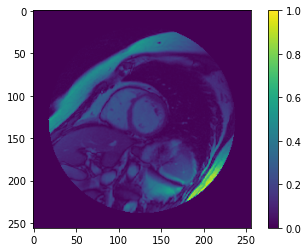

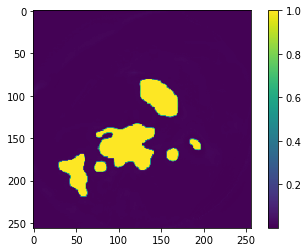

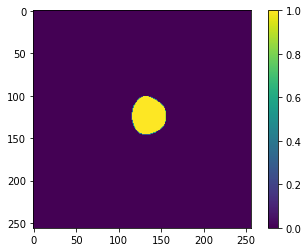

In [26]:
img,label = next(iter(test_dataloader))

model = model.to(device)
img = img.to(device)
output = model.forward(img)

print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

img = img.cpu().squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

output = output.cpu().detach().numpy().squeeze()
plt.imshow(output)
plt.colorbar()
plt.show()


label = label.cpu().squeeze()
plt.imshow(label)
plt.colorbar()

plt.show()


#img = wandb.Image(img, caption="Input image")
#label = wandb.Image(label, caption="Mask image")
#output = wandb.Image(output, caption="U-Net output")
          
#wandb.log({"Input": img, "label":label, "output":output})


# Test

In [25]:
#Model saving

EPOCH = 20
PATH = "Unet_512.pt"
learning_rate = 0.001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'learning_rate': learning_rate,
            }, PATH)

In [ ]:
PATH = "Unet.pt"

model = Unet()
model = model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
print(model)

In [ ]:
img,label = next(iter(valid_dataloader))

output = model.forward(img)
#print(f"Accuracy : {dice_metric(output,label)*100} %")


intersection = 2.0* (output*label).sum()
output.sum()

In [ ]:
def dice_metric(output,label):

  intersection = 2.0* (output*label).sum()
  union = output.sum()+label.sum()

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union